In [1]:
import pandas as pd
import numpy as np
import os
import sys
import networkx as nx

In [2]:
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [3]:
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [66]:
from construct_dataframes import get_projects_df, get_methods_df, get_clones_df, get_unique_clones_df
from clones_features_builder import add_number_of_clones_features, add_number_of_projects_features
from clones_graph_analysis import get_graph, add_graph_features
from code_features_utils import add_code_features, is_method_empty
from construct_large_clones_dataframes import count_clones_statistics, get_unique_clones_df_large, \
    add_features_from_stats
from column_names_utils import ClonesColumn, MethodsColumn

from utils import create_directory

In [5]:
def pretty_print(df):
    return df.style.set_properties(**{'text-align': 'left', 'white-space': 'pre'})

In [6]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

Set correct paths to the dataset, plugin output and clones data

In [7]:
dataset_path = "/path/to/dataset/dir"
plugin_output_path = "/path/to/extracted_methods/dir"
clones_folder_path = "/path/to/clones/dir"

In [88]:
methods_df = get_methods_df(plugin_output_path)
projects_df = get_projects_df(plugin_output_path)

In [11]:
# create directory for the results of this analysis
ratings_directory_name = "clones_rating"
create_directory(ratings_directory_name)

In this part we use clones for methods, that has at least 19 tokens.

In [12]:
path80 = os.path.join(clones_folder_path, "results80_big.pairs")
path100 = os.path.join(clones_folder_path, "results100_big.pairs")
clones = get_clones_df(path80, path100)

In [13]:
clones[clones['is_in_project'] == True]

,project1_id,method1_id,project2_id,method2_id,closeness,is_in_project
0,0,7,0,6,80,True
1,0,60,0,54,80,True
2,1,150,1,149,80,True
3,1,156,1,155,80,True
4,1,158,1,155,80,True
...,...,...,...,...,...,...
519408,10440,3229911,10440,3229789,100,True
519409,10440,3229911,10440,3229894,100,True
519410,10440,3229948,10440,3229842,100,True
519412,10440,3230543,10440,3230542,100,True


In [85]:
clones[(clones[ClonesColumn.CLOSENESS] == 100) & (clones[ClonesColumn.IS_IN_PROJECT] == False)]

,project1_id,method1_id,project2_id,method2_id,closeness,is_in_project
14536,70,28923,4,686,100,False
14631,111,36461,3,363,100,False
14632,111,36583,32,14434,100,False
14633,111,36585,32,14436,100,False
14956,148,67105,141,66174,100,False
...,...,...,...,...,...,...
519402,10440,3227849,3949,1218003,100,False
519403,10440,3227851,3949,1218005,100,False
519404,10440,3227847,3949,1218001,100,False
519405,10440,3227848,3949,1218002,100,False


Feature computing is based on the graph of clones. 
It is ok for a medium size graph, but for the large amount of clones it is better to use approach provided below.

In [91]:
graph = get_graph(clones)
components = sorted(nx.connected_components(graph), key=len, reverse=True)
add_graph_features(methods_df, components)

In [92]:
add_number_of_clones_features(methods_df, graph)
add_number_of_projects_features(methods_df, graph)

**The first way to filter only unique methods from the dataframe is to keep one method (leader) from each component of the graph of clones.**

In [93]:
leaders = methods_df[methods_df[MethodsColumn.LEADER_METHOD_ID] ==  methods_df.index][methods_df[MethodsColumn.N_CLONES] > 1]
leaders.sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS], inplace=True, ascending=False)

<ipython-input-93-595ed1fc9b48>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  leaders = methods_df[methods_df[MethodsColumn.LEADER_METHOD_ID] ==  methods_df.index][methods_df[MethodsColumn.N_CLONES] > 1]


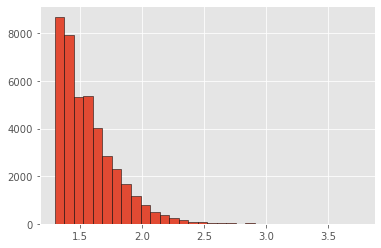

In [94]:
plt.hist(np.log10(1 + leaders[MethodsColumn.TOKENS]), bins=32, edgecolor='black')
plt.show()

In [95]:
add_code_features(leaders, dataset_path)

In [96]:
pretty_print(leaders[[MethodsColumn.METHOD_ID, MethodsColumn.N_UNIQUE_PROJECTS_COMPONENT, MethodsColumn.HIGHLIGHTED_CODE]]
             .sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS_COMPONENT], ascending=False)
             .head(n=5))

,method_id,n_unique_projects_component,highlighted_code
1646592,1646592,1847,"override fun onCreateViewHolder(parent: ViewGroup?, viewType: Int): ViewHolder { val layoutInflater = LayoutInflater.from(parent?.context) return ViewHolder(ItemDiffBinding.inflate(layoutInflater, parent, false)) }"
1474573,1474573,990,"override fun onCreateView(inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle?): View? { setHasOptionsMenu(true) return inflater.inflate(R.layout.fragment_main, container, false) }"
3170307,3170307,875,override fun onOptionsItemSelected(item: MenuItem): Boolean { val id: Int = item.itemId if (id == android.R.id.home) { onBackPressed() return true } return super.onOptionsItemSelected(item) }
1056775,1056775,774,override fun equals(other: Any?): Boolean { if (this === other) return true if (other !is DependencyManagementKey) return false if (groupId != other.groupId) return false if (name != other.name) return false if (classifier != other.classifier) return false if (type != other.type) return false return true }
718850,718850,411,override fun hashCode(): kotlin.Int { var result = super.hashCode() result = 31 * result + name.hashCode() result = 31 * result + fields.hashCode() return result }


In [97]:
leaders_head = leaders.sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS_COMPONENT], ascending=False).head(n=30)
leaders_head.to_csv(f"{ratings_directory_name}/component_leaders.csv")

**Another way to keep only unique popular methods, is to sort them in descending order and take only those methods, who has no clones in already saved subset of methods.**

In [100]:
unique_clones_medium = get_unique_clones_df(methods_df, graph)

<ipython-input-99-6940f61f22bb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  methods_records = methods_df.sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS.value], ascending=False)[


In [116]:
add_code_features(unique_clones_medium, dataset_path)

In [102]:
pretty_print(unique_clones_medium[[MethodsColumn.METHOD_ID, MethodsColumn.N_UNIQUE_PROJECTS, MethodsColumn.HIGHLIGHTED_CODE]]
             .sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS], ascending=False)
             .head(n=5))

,method_id,n_unique_projects,highlighted_code
1412967,1412967,717,"override fun onCreateViewHolder(parent: ViewGroup, viewType: Int): ViewHolder { val view = LayoutInflater.from(parent.context) .inflate(R.layout.list_item, parent, false) return ViewHolder(view) }"
871877,871877,546,override fun onOptionsItemSelected(item: MenuItem): Boolean { when (item.itemId) { android.R.id.home -> { onBackPressed() return true } else -> return super.onOptionsItemSelected(item) } }
1445621,1445621,450,"override fun onCreateViewHolder(parent: ViewGroup, viewType: Int): ViewHolder { return NumPadItemViewHolder(LayoutInflater.from(parent.context).inflate(R.layout.view_numpad_button, parent, false)) }"
3168173,3168173,340,override fun onOptionsItemSelected(item: MenuItem?): Boolean { item?.let { if (it.itemId == android.R.id.home) finish() } return super.onOptionsItemSelected(item) }
699011,699011,320,"override fun onCreateView( inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle? ): View? { val binding = FragmentDetailBinding.inflate(inflater, container, false) return binding.root }"


In [105]:
unique_clones_medium.columns

Index(['project_id', 'method_id', 'file', 'start_line', 'end_line', 'tokens',
       'leader_method_id', 'component_size', 'n_unique_projects_component',
       'n_clones', 'n_inter_clones', 'n_100_clones', 'n_inter_100_clones',
       'n_unique_projects', 'n_unique_100_projects', 'method_text',
       'highlighted_code'],
      dtype='object')

**Save exact clones and near-miss clones ratings:**

In [103]:
unique_exact_clones_medium_head = unique_clones_medium.sort_values(by=[MethodsColumn.N_UNIQUE_100_PROJECTS], ascending=False)\
    .head(n=30)
unique_exact_clones_medium_head.to_csv(f"{ratings_directory_name}/exact_clones_19_tokens.csv")

In [104]:
unique_clones_medium_head = unique_clones_medium.sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS], ascending=False).head(n=30)
unique_clones_medium_head.to_csv(f"{ratings_directory_name}/clones_19_tokens.csv")

### More clones!

In this part we use clones for methods, that has at least 5 tokens. It is difficult to build a graph for such amount of data, so the analysis part is based on the one pass of adjacency list (there is script for building it).

In [53]:
# start from scratch without already computed features
methods_df = get_methods_df(plugin_output_path)

In [54]:
# it could take a while...
methods_stats, clones_adjacency_top = count_clones_statistics(os.path.join(clones_folder_path, "clones_adjacency.txt"))

In [55]:
methods_df = add_features_from_stats(methods_df, methods_stats)

In [56]:
unique_clones_large = get_unique_clones_df_large(methods_df, clones_adjacency_top)

In [57]:
add_code_features(unique_clones_large, dataset_path)

In [114]:
# filter empty methods
unique_clones_large[MethodsColumn.IS_EMPTY.value] = unique_clones_large[MethodsColumn.METHOD_TEXT].apply(lambda text: is_method_empty(text))
filtered_unique_clones_large = unique_clones_large[~unique_clones_large[MethodsColumn.IS_EMPTY]].drop(columns=[MethodsColumn.IS_EMPTY])

In [115]:
filtered_unique_clones_large.columns

Index(['project_id', 'method_id', 'file', 'start_line', 'end_line', 'tokens',
       'n_clones', 'n_inter_clones', 'n_100_clones', 'n_inter_100_clones',
       'n_unique_projects', 'n_unique_100_projects', 'method_text',
       'highlighted_code'],
      dtype='object')

Print and save exact and near-miss clones

In [61]:
unique_exact_clones_large_head = filtered_unique_clones_large.sort_values(by=[MethodsColumn.N_UNIQUE_100_PROJECTS], ascending=False)\
    .head(n=30)
unique_exact_clones_large_head.to_csv(f"{ratings_directory_name}/exact_clones_5_tokens.csv")

In [106]:
pretty_print(unique_exact_clones_large_head[[MethodsColumn.TOKENS, MethodsColumn.N_UNIQUE_100_PROJECTS, MethodsColumn.N_UNIQUE_PROJECTS, 
                                             MethodsColumn.N_CLONES, MethodsColumn.N_INTER_CLONES, MethodsColumn.HIGHLIGHTED_CODE]])

,tokens,n_unique_100_projects,n_unique_projects,n_clones,n_inter_clones,highlighted_code
2591,7,2897,2950,9949,9921,"@Test fun addition_isCorrect() { assertEquals(4, 2 + 2) }"
18665,6,278,460,1846,1846,override fun describeContents(): Int { return 0 }
3917,5,187,968,2392,2385,override fun getItemCount() = items.size
5673,8,179,358,754,752,override fun onBind(intent: Intent): IBinder? { return null }
6138,9,168,346,885,885,override fun getItemId(position: Int): Long { return position.toLong() }
20311,6,158,236,572,572,@BindsInstance fun application(application: Application): Builder
1030,5,147,164,322,322,@MainThread fun call() { value = null }
49210,7,123,215,1439,1437,override fun onDestroyView() { _binding = null super.onDestroyView() }
6199,11,121,130,271,271,fun getContentIfNotHandled(): T? { return if (hasBeenHandled) { null } else { hasBeenHandled = true content } }
6697,11,119,147,276,276,override fun attachBaseContext(base: Context) { super.attachBaseContext(base) MultiDex.install(this) }


In [63]:
unique_clones_large_head = filtered_unique_clones_large.sort_values(by=[MethodsColumn.N_UNIQUE_PROJECTS], ascending=False).head(n=30)
unique_clones_large_head.to_csv(f"{ratings_directory_name}/clones_5_tokens.csv")

In [107]:
pretty_print(unique_clones_large_head[[MethodsColumn.TOKENS, MethodsColumn.N_UNIQUE_100_PROJECTS, MethodsColumn.N_UNIQUE_PROJECTS, 
                                       MethodsColumn.N_CLONES, MethodsColumn.N_INTER_CLONES, MethodsColumn.HIGHLIGHTED_CODE]])

,tokens,n_unique_100_projects,n_unique_projects,n_clones,n_inter_clones,highlighted_code
2591,7,2897,2950,9949,9921,"@Test fun addition_isCorrect() { assertEquals(4, 2 + 2) }"
644392,6,4,1768,3909,3909,override fun getItemCount(): Int { return size }
162183,10,3,1634,3184,3182,override fun onCreate(savedInstanceState: Bundle?) { super.onCreate(savedInstanceState) setContentView(layout) }
206473,17,2,1497,5501,5498,"override fun onCreateView( inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle? ): View? { return DonutEntryDialogBinding.inflate(inflater, container, false).root }"
102645,13,19,1347,2378,2373,override fun onCreate(savedInstanceState: Bundle?) { super.onCreate(savedInstanceState) setContentView(R.layout.activity_main) initView() }
1046661,16,1,1328,4795,4794,"override fun onCreateView(inflater: LayoutInflater?, container: ViewGroup?, savedInstanceState: Bundle?): View? = inflate(R.layout.main_fragment, inflater, container)"
516285,20,1,1287,4845,4838,"override fun onCreateView(inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle?): View? { return super.onCreateView(inflater.inflate(R.layout.fragment_main_container, container, false)) }"
427400,15,1,1152,2266,2265,"@Test fun useAppContext() { // Context of the app under test. val appContext = InstrumentationRegistry.getInstrumentation().targetContext assertEquals(""com.dev.minread.test"", appContext.packageName) }"
1160882,18,1,1144,4322,4321,"override fun onCreateView(inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle?) = inflater.inflate(R.layout.fragment_bookmarks, container, false) as ViewGroup"
801503,18,1,1141,4292,4291,"@SuppressLint(""SetTextI18n"") override fun onCreateView( inflater: LayoutInflater, container: ViewGroup?, savedInstanceState: Bundle? ): View? = inflater.inflate(layout.child_fragment_sample, container, false)"
